In [1]:
using QHDLJ
using PyPlot

## Initializing individual components

In [2]:
kappas = [1., 1.]
Delta = 0.
cav = single_mode_cavity(kappas, Delta)

u_t = make_inputs(cav, ["In1"], t -> [t])

tlist = linspace(-10, 10, 201)
z0 = find_fixpoint(cav, [0.0im], tlist[1]; u_t=u_t)
nle_det = solve_nlsystem(cav, z0, tlist, .05; u_t=u_t, sde=false)
nle_stoch = solve_nlsystem(cav, z0, tlist, .05; u_t=u_t)

[..........|..........|..........|..........|.........]
[.

[NLEvolution: 
	stochastic=true,
	input=true,
	201 timesteps from -10.0 to 10.0,
	NLSystem: 
		[NLComponent: 1 modes, 2 ports, modes: [m1], inputs: [In1, In2], outputs: [Out1, Out2], internal: []]]

.........|..........|..........|..........|.........]


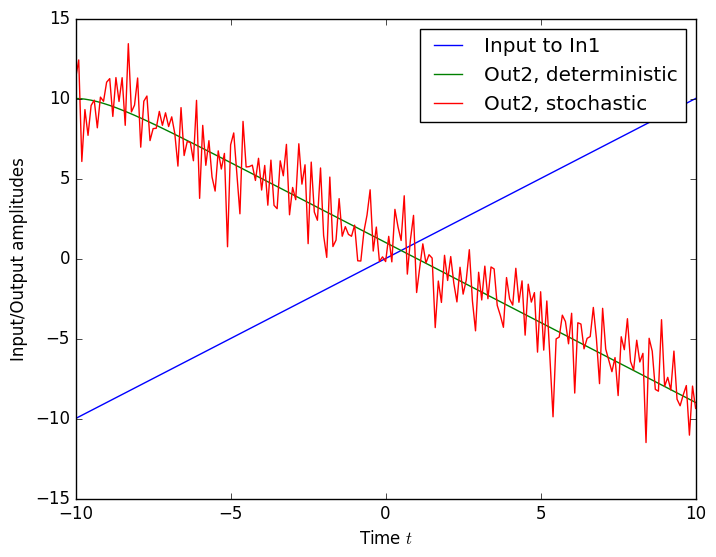

PyObject <matplotlib.legend.Legend object at 0x31f4c0e80>

In [3]:
ii = inputs(nle_det, ["In1"])
o_det = outputs(nle_det, ["Out2"])
o_stoch = outputs(nle_stoch, ["Out2"], add_noise=true)
plot(tlist, real(ii), label="Input to In1")
plot(tlist, real(o_det), label="Out2, deterministic")
plot(tlist, real(o_stoch), label="Out2, stochastic")
xlabel(L"Time $t$")
ylabel("Input/Output amplitudes")
legend()

## Non-linear components

In [4]:
kappas = [1., 1.]
Delta = 1.6
chi = -.01
kcav = single_mode_kerr_cavity(kappas, Delta, chi)

[NLComponent: 1 modes, 2 ports, modes: [m1], inputs: [In1, In2], outputs: [Out1, Out2], internal: []]

In [5]:
u_t = make_inputs(kcav, ["In1"], t -> [t/2])

tlist = linspace(0, 60, 201)
z0 = find_fixpoint(kcav, [0.0im], tlist[1]; u_t=u_t)
nle_det = solve_nlsystem(kcav, z0, tlist, .05; u_t=u_t, sde=false)
nle_stoch = solve_nlsystem(kcav, z0, tlist, .05; u_t=u_t)

[.

[NLEvolution: 
	stochastic=true,
	input=true,
	201 timesteps from 0.0 to 60.0,
	NLSystem: 
		[NLComponent: 1 modes, 2 ports, modes: [m1], inputs: [In1, In2], outputs: [Out1, Out2], internal: []]]

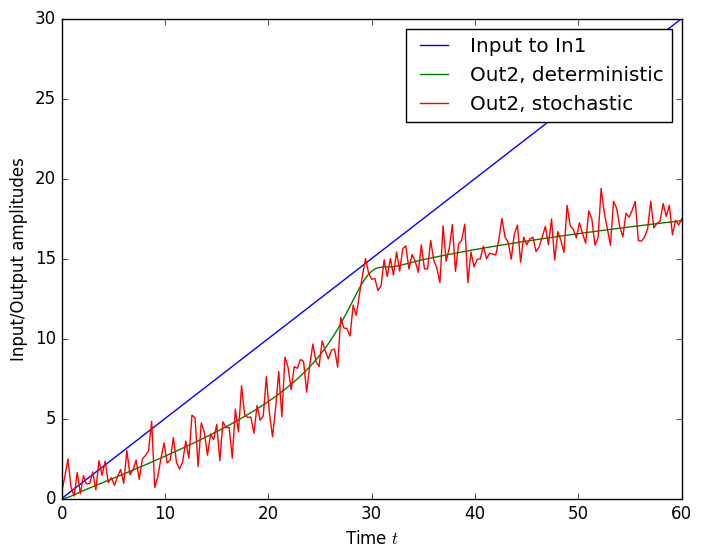

PyObject <matplotlib.legend.Legend object at 0x31f5c54a8>

.........|..........|..........|..........|..........|..........|..........|..........|..........|.........]
[..........|..........|..........|..........|..........|..........|..........|..........|..........|.........]


In [6]:
ii = inputs(nle_det, ["In1"])
o_det = outputs(nle_det, ["Out2"])
o_stoch = outputs(nle_stoch, ["Out2"], add_noise=true)
plot(tlist, real(ii), label="Input to In1")
plot(tlist, abs(o_det), label="Out2, deterministic")
plot(tlist, abs(o_stoch), label="Out2, stochastic")
xlabel(L"Time $t$")
ylabel("Input/Output amplitudes")
legend()

## Circuits

In [7]:
kcavs = nlcircuit(
Dict( # components for circuit
    "K1"=>kcav,
    "K2"=>kcav,
    ),
[
    # internal connections: Compname1 output1 Compname2 input2
    "K1" "Out2" "K2" "In1"
],
[
    # global Inputs: Name Compname Input
    "InOverall" "K1" "In1"
],
[
    # global Outputs: Name Compname Output
    "OutOverall" "K2" "Out2"
]
)

[NLCircuit:
	 Components: {
		K2 => [NLComponent: 1 modes, 2 ports, modes: [m1], inputs: [In1, In2], outputs: [Out1, Out2], internal: []],
		K1 => [NLComponent: 1 modes, 2 ports, modes: [m1], inputs: [In1, In2], outputs: [Out1, Out2], internal: []],
	},
	Global inputs: {
		InOverall => K1:In1,
	},
	Global outputs: {
		OutOverall => K2:Out2,
		},
	Connections: [
		K1:Out2 -> K2:In1,
	]]

In [8]:
# flatten into component
kcavsc = NLComponent(kcavs)

[NLComponent: 2 modes, 3 ports, modes: [K2.m1, K1.m1], inputs: [K2.In2, InOverall, K1.In2], outputs: [K2.Out1, OutOverall, K1.Out1], internal: [K1.Out2]]

In [9]:
u_t = make_inputs(kcavsc, ["InOverall"], t -> [t/4])

tlist = linspace(0, 120, 201)
z0 = find_fixpoint(kcavsc, [0.0im, 0.0im], tlist[1]; u_t=u_t)
nle_det = solve_nlsystem(kcavsc, z0, tlist, .05; u_t=u_t, sde=false)
nle_stoch = solve_nlsystem(kcavsc, z0, tlist, .05; u_t=u_t)

[.

[NLEvolution: 
	stochastic=true,
	input=true,
	201 timesteps from 0.0 to 120.0,
	NLSystem: 
		[NLComponent: 2 modes, 3 ports, modes: [K2.m1, K1.m1], inputs: [K2.In2, InOverall, K1.In2], outputs: [K2.Out1, OutOverall, K1.Out1], internal: [K1.Out2]]]

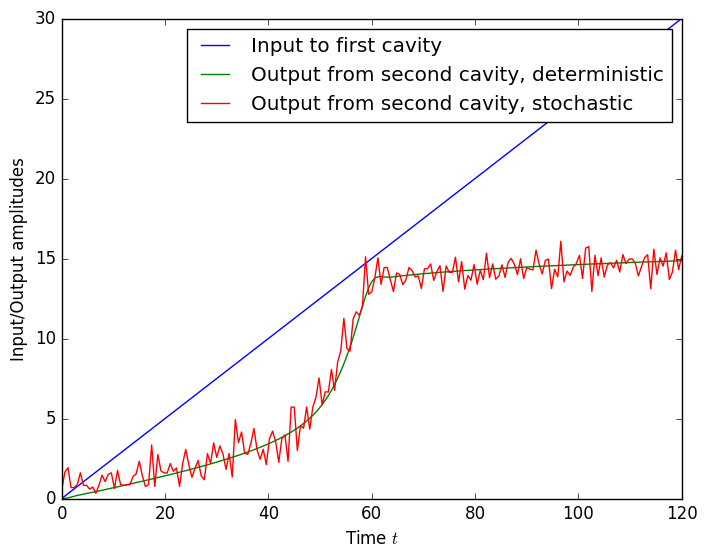

PyObject <matplotlib.legend.Legend object at 0x31f7be048>

.........|..........|..........|..........|..........|..........|..........|..........|..........|.........]
[..........|..........|..........|..........|..........|..........|..........|..........|..........|.........]


In [10]:
ii = inputs(nle_det, ["InOverall"])
o_det = outputs(nle_det, ["OutOverall"])
o_stoch = outputs(nle_stoch, ["OutOverall"], add_noise=true)
plot(tlist, real(ii), label="Input to first cavity")
plot(tlist, abs(o_det), label="Output from second cavity, deterministic")
plot(tlist, abs(o_stoch), label="Output from second cavity, stochastic")
xlabel(L"Time $t$")
ylabel("Input/Output amplitudes")
legend()

## Transferfunction for perturbations around z = z(t=60)

In [11]:
zt60 = nle_det.zts[:,101]

2-element Array{Complex{Float64},1}:
  12.6867+4.75576im
 -13.2811-4.61895im

In [12]:
# complex transfer function at DC (=>omega=0)
TF = transferfunction_ee(kcavsc, zt60, ["InOverall"], ["OutOverall"])

2x2x1x1 Array{Complex{Float64},4}:
[:, :, 1, 1] =
 -0.0497246+0.909065im   -0.472023+0.639084im
  -0.472023-0.639084im  -0.0497246-0.909065im

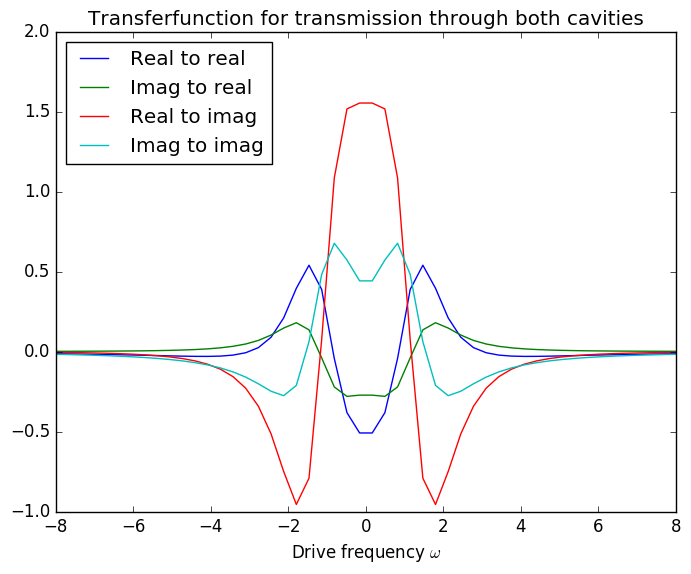

PyObject <matplotlib.text.Text object at 0x31f7e8400>

In [13]:
omegas = linspace(-8, 8)
TF_quadrature_rep = transferfunction_ee(kcavsc, zt60,["InOverall"], ["OutOverall"], omegas; quadrep=true) |> real
plot(omegas, TF_quadrature_rep[1,1,1,1,:][:], label="Real to real ")
plot(omegas, TF_quadrature_rep[1,2,1,1,:][:], label="Imag to real")
plot(omegas, TF_quadrature_rep[2,1,1,1,:][:], label="Real to imag")
plot(omegas, TF_quadrature_rep[2,2,1,1,:][:], label="Imag to imag")
legend(loc="upper left")
title("Transferfunction for transmission through both cavities")
xlabel(L"Drive frequency $\omega$")

## Non-degenerate OPO

[.

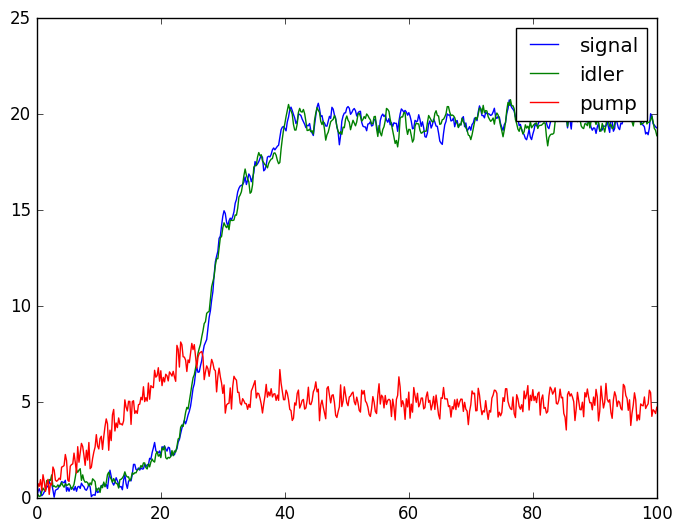

PyObject <matplotlib.legend.Legend object at 0x31fb28128>

.........|..........|..........|..........|..........|..........|..........|..........|..........|.........]


In [14]:
chi2 = .1
ks, ki, kp = 1., 1., 10.
nopo = nd_opo([ks, ki, kp], chi2)

u_t = make_inputs(nopo, ["signal", "pump"], t->[0., min(t/2, 20)])
tlist = linspace(0, 100, 501)
nle = solve_nlsystem(nopo, zeros(Complex128, 3), tlist, .05; u_t=u_t)
plot(tlist, nle.zts.' |> abs)
legend(nopo.modes)

## Phase diffusion

[..........|..........|..........|..........|..........|..........|..........|..........|..........|........

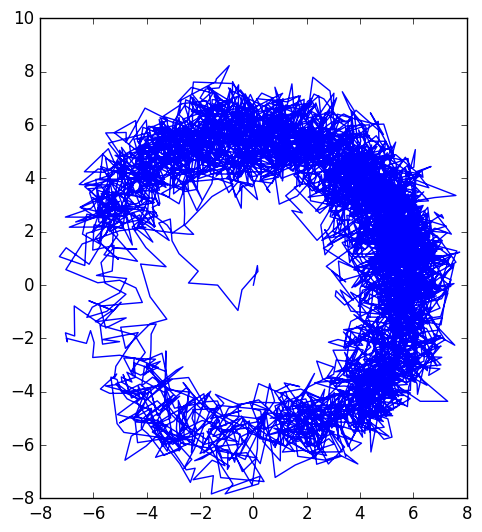

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x322bc8668>

.]


In [15]:
u_t = make_inputs(nopo, ["signal", "pump"], t->[0., 9])
tlist = linspace(0, 10000, 5001)

nle = solve_nlsystem(nopo, zeros(Complex128, 3), tlist, .05; u_t=u_t)

sigts = modes(nle, ["signal"])[:]
axes(aspect=1)
plot(sigts|> real, sigts |> imag)